# Python

*** 

## 1. Python import and define functions

In [12]:
# Python import
import os
import copy
import random
import collections
import itertools
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import lightgbm as lgb
import warnings
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [3]:
# Whether in jupyter notebook
def isnotebook() -> bool:
    """
    Returns True if the current execution environment is a jupyter notebook
    https://stackoverflow.com/questions/15411967/how-can-i-check-if-code-is-executed-in-the-ipython-notebook
    """
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [4]:
#get filepath of input and output
def get_filepath():
    parser = argparse.ArgumentParser()
    parser.add_argument("-C","-c","--cyto",dest = "cytosol", help = "Cytosol instances file")
    parser.add_argument("-N","-n","--nuc",dest = "nuclear",help = "Nuclear instances file")
    args = parser.parse_args()
    return args

In [5]:
# Count the frequency of k-mer in each RNA sequence
# k-mer was normalized by total k-mer count of each RNA sequence
def _count_kmer(Dataset,k): # k = 3,4,5
    
    # copy dataset
    dataset = copy.deepcopy(Dataset)
    # alphbet of nucleotide
    nucleotide = ['A','C','G','T']
    
    # generate k-mers
    #  k == 5:
    five = list(itertools.product(nucleotide,repeat=5))
    pentamer = []
    for n in five:
        pentamer.append("".join(n))
    
    #  k == 4:
    four = list(itertools.product(nucleotide,repeat=4))
    tetramer = []
    for n in four:
        tetramer.append("".join(n))

    # k == 3:
    three = list(itertools.product(nucleotide,repeat=3))
    threemer = []
    for n in three:
        threemer.append("".join(n))
    
    # input features can be combinations of diffrent k values
    if k == 34:
        table_kmer = dict.fromkeys(threemer,0)
        table_kmer.update(dict.fromkeys(tetramer,0))
    if k == 45:
        table_kmer = dict.fromkeys(tetramer,0)
        table_kmer.update(dict.fromkeys(pentamer,0))
    if k == 345:
        table_kmer = dict.fromkeys(threemer,0)
        table_kmer.update(dict.fromkeys(tetramer,0))
        table_kmer.update(dict.fromkeys(pentamer,0))

    # count k-mer for each sequence
    for mer in table_kmer.keys():
        table_kmer[mer] = dataset["cdna"].apply(lambda x : x.count(mer))
    
    # for k-mer raw count without normalization, index: nuc:1 or cyto:0
    rawcount_kmer_df = pd.DataFrame(table_kmer)
    df1_rawcount = pd.concat([rawcount_kmer_df,dataset["ensembl_transcript_id"]],axis = 1)
    df1_rawcount.index = dataset["tag"]

    # for k-mer frequency with normalization , index: nuc:1 or cyto:0
    freq_kmer_df = rawcount_kmer_df.apply(lambda x: x/x.sum(),axis=1)
    df1 = pd.concat([freq_kmer_df,dataset["ensembl_transcript_id"]],axis = 1)
    df1.index = dataset["tag"]

    return df1,df1_rawcount

In [6]:
#Evaluate performance of model
def evaluate_performance(y_test, y_pred, y_prob):
    # AUROC
    auroc = metrics.roc_auc_score(y_test,y_prob)
    auroc_curve = metrics.roc_curve(y_test, y_prob)
    # AUPRC
    auprc=metrics.average_precision_score(y_test, y_prob) 
    auprc_curve=metrics.precision_recall_curve(y_test, y_prob)
    #Accuracy
    accuracy=metrics.accuracy_score(y_test,y_pred) 
    #MCC
    mcc=metrics.matthews_corrcoef(y_test,y_pred)
    
    recall=metrics.recall_score(y_test, y_pred)
    precision=metrics.precision_score(y_test, y_pred)
    f1=metrics.f1_score(y_test, y_pred)
    class_report=metrics.classification_report(y_test, y_pred,target_names = ["control","case"])

    model_perf = {"auroc":auroc,"auroc_curve":auroc_curve,
                  "auprc":auprc,"auprc_curve":auprc_curve,
                  "accuracy":accuracy, "mcc": mcc,
                  "recall":recall,"precision":precision,"f1":f1,
                  "class_report":class_report}
        
    return model_perf

In [7]:
# Output result of evaluation
def eval_output(model_perf,path):
    with open(os.path.join(path,"Evaluate_Result_TestSet.txt"),'w') as f:
        f.write("AUROC=%s\tAUPRC=%s\tAccuracy=%s\tMCC=%s\tRecall=%s\tPrecision=%s\tf1_score=%s\n" %
               (model_perf["auroc"],model_perf["auprc"],model_perf["accuracy"],model_perf["mcc"],model_perf["recall"],model_perf["precision"],model_perf["f1"]))
        f.write("\n######NOTE#######\n")
        f.write("#According to help_documentation of sklearn.metrics.classification_report:in binary classification, recall of the positive class is also known as sensitivity; recall of the negative class is specificity#\n\n")
        f.write(model_perf["class_report"])

In [8]:
# Plot AUROC of model
def plot_AUROC(model_perf,path):
    #get AUROC,FPR,TPR and threshold
    roc_auc = model_perf["auroc"]
    fpr,tpr,threshold = model_perf["auroc_curve"]
    #return AUROC info
    temp_df = pd.DataFrame({"FPR":fpr,"TPR":tpr})
    temp_df.to_csv(os.path.join(path,"AUROC_info.txt"),header = True,index = False, sep = '\t')
    #plot
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='AUROC (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUROC of Models")
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(path,"AUROC_TestSet.pdf"),format = "pdf")

*** 
###   

##  2. Configution

In [9]:
# Random seed
SEED = 100
random.seed(SEED)
np.random.seed(SEED)

warnings.filterwarnings(action='ignore')

# Output dir
output_dir = "01_RNAlight_Model_Output"
if not (os.path.exists(output_dir)):
    os.mkdir(output_dir)

*** 
###   

## 3. Data Processing

In [14]:
%%time
print("\n********************** Start Data Processing **************************")

# Load dataset files
Training_set_sequence = pd.read_csv("/data/rnomics8/yuanguohua/RNAlight_Private/mRNA/03_Model_Construction/mRNA_sublocation_TrainingSet.tsv",sep='\t')
Training_set_structure = pd.read_csv("../../Structure_Dataset/mRNA/mRNA_sublocation_TrainingSet_structure.txt",sep='\t')
Training_set_property = pd.read_csv("../../Property_Dataset/mRNA/mRNA_sublocation_TrainingSet_biochemical.txt",sep='\t')

Test_set_sequence = pd.read_csv("/data/rnomics8/yuanguohua/RNAlight_Private/mRNA/03_Model_Construction/mRNA_sublocation_TestSet.tsv",sep='\t')
Test_set_structure = pd.read_csv("../../Structure_Dataset/mRNA/mRNA_sublocation_TestSet_structure.txt",sep='\t')
Test_set_property = pd.read_csv("../../Property_Dataset/mRNA/mRNA_sublocation_TestSet_biochemical.txt",sep='\t')


# k = 3,4,5 count the normalized and raw count of kmer
Train_df_kmer_345,Train_df_kmer_345_rawcount = _count_kmer(Training_set_sequence,345)
del Train_df_kmer_345['ensembl_transcript_id']
# Structure info
Train_df_strcutrue  = Training_set_structure.iloc[:,2:]
# property info
Train_df_property  = Training_set_property.iloc[:,1:]
# Z-Score using scipy
Train_df_property['length'] = stats.zscore(Train_df_property['length'])
Train_df_property['MFE'] = stats.zscore(Train_df_property['MFE'])

# k = 3,4,5 count the normalized and raw count of kmer
Test_df_kmer_345,Test_df_kmer_345_rawcount = _count_kmer(Test_set_sequence,345)
del Test_df_kmer_345['ensembl_transcript_id']
# Structure info
Test_df_strcutrue  = Test_set_structure.iloc[:,2:]
# property info
Test_df_property  = Test_set_property.iloc[:,1:]
# Z-Score using scipy
Train_df_property['length'] = stats.zscore(Train_df_property['length'])
Train_df_property['MFE'] = stats.zscore(Train_df_property['MFE'])

# Combine kmer and structure_info
x_train = pd.concat([pd.DataFrame(Train_df_kmer_345.values,columns = Train_df_kmer_345.columns),Train_df_strcutrue, Train_df_property],axis = 1)
y_train = np.array(Train_df_kmer_345.index)

x_test = pd.concat([pd.DataFrame(Test_df_kmer_345.values,columns = Test_df_kmer_345.columns),Test_df_strcutrue, Test_df_property],axis = 1)
y_test = np.array(Test_df_kmer_345.index)

print("\n********************** Finished Data Processing ***********************")


********************** Start Data Processing **************************

********************** Finished Data Processing ***********************
CPU times: user 1min 19s, sys: 434 ms, total: 1min 20s
Wall time: 1min 20s


- LightGBM


*** LightGBM ***
CPU times: user 1min 24s, sys: 6.79 s, total: 1min 31s
Wall time: 5h 23min 27s


['01_RNAlight_Model_Output/LightGBM/best_LightGBM_model.pkl']

<Figure size 432x288 with 0 Axes>

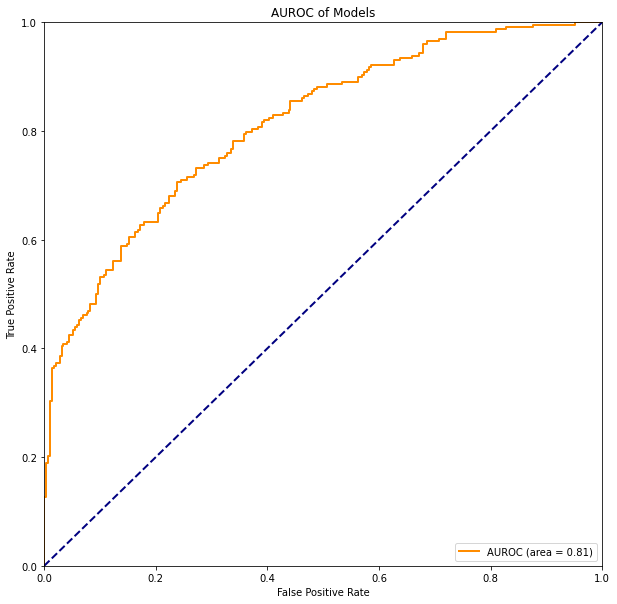

In [15]:
%%time
print("\n*** LightGBM ***")

# LightGBM params
lgb_param_dict = {
    "learning_rate":[0.1, 0.05, 0.02, 0.01],
    "num_leaves": range(10,36,5),
    "max_depth" : [2,3,4,5,10,20,40,50],
    "n_estimators" : range(100,2500,100),
    
    "min_child_samples": range(1, 45, 2),
    "colsample_bytree" : [i / 10 for i in range(2,11)],
    "metric" : ["binary_logloss"],
    "n_jobs":[1],
    "subsample" :  [i / 10 for i in range(2, 11)],
    "subsample_freq" : [0, 1, 2],
    "reg_alpha" : [0, 0.001, 0.005, 0.01, 0.1],
    "reg_lambda" : [0, 0.001, 0.005, 0.01, 0.1],
    "objective":["binary"],
    "random_state":[SEED]
}

#Initiate model
lgb_model = lgb.LGBMClassifier()
#Adjust hyper-parameters with 5-fold cross validation
lgb_rscv = RandomizedSearchCV(lgb_model, lgb_param_dict, n_iter=1000,cv = 5,verbose = 0,
                          scoring = "roc_auc",random_state=SEED,n_jobs = 30)
lgb_rscv.fit(x_train, y_train)   


#Evaluate best LightGBM model
#Output path
path = os.path.join(output_dir,"LightGBM")
if not (os.path.exists(path)):
    os.mkdir(path)
    
# Model performance(AUROC) on cross-validation dataset
lgb_cv_perf = np.array([ lgb_rscv.cv_results_["split%s_test_score"%str(i)] for i in range(5)])[:,lgb_rscv.best_index_]

#Get best model with score [max(mean(auc(5 cross validation)))]
lgb_best_model = lgb_rscv.best_estimator_
#Get predict_class(y_pred) and predict_probality_for_case(y_prob) of TestSet
y_pred = lgb_best_model.predict(x_test)
y_prob = lgb_best_model.predict_proba(x_test)[:,1]

#Get model performance
model_perf = evaluate_performance(y_test,y_pred,y_prob)
#Output result of evaluation
eval_output(model_perf,path)
#You can make bar plot consisted of accuracy,sensitivity,specificity,auroc,f1 score,MCC,precision,recall,auprc according to the "Evaluate_Result_TestSet.txt"
# Plot AUROC
plot_AUROC(model_perf,path)

#save model
joblib.dump(lgb_best_model,os.path.join(path,"best_LightGBM_model.pkl"))
#load model
#lgb_best_model = joblib.load(os.path.join(path,"best_LightGBM_model.pkl"))

## 4. Output performance on cross-validation set

In [16]:
ML_CV_result = pd.DataFrame({"lgb_structure_property":lgb_cv_perf})
ML_CV_result.to_csv(os.path.join(output_dir,"ML_CV_result.tsv"),sep = '\t',index = False)

*** 
###   